**VGG16 model to detect COVID-19 using Chest x-ray images.**

**Exploratory Data Analysis**

I will be using the VGG16 model to detect Chest x-ray images that match with Chest x-ray images COVID-19. 

List of classes of chest X-ray images given in the dataset

* Normal pneumonia.
* COVID-19.
* Viral pneumonia chest.
* Lung Opacity (Non-COVID lung infection).

VGG16 is a convolutional neural network that is 16 layers deep. VGG16 has convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture.
In the end it has 2 FC(fully connected layers) followed by a softmax for output. The 16 in VGG16 refers to it has 16 layers that have weights. This network is a pretty large network and it has about 138 million (approx) parameters.
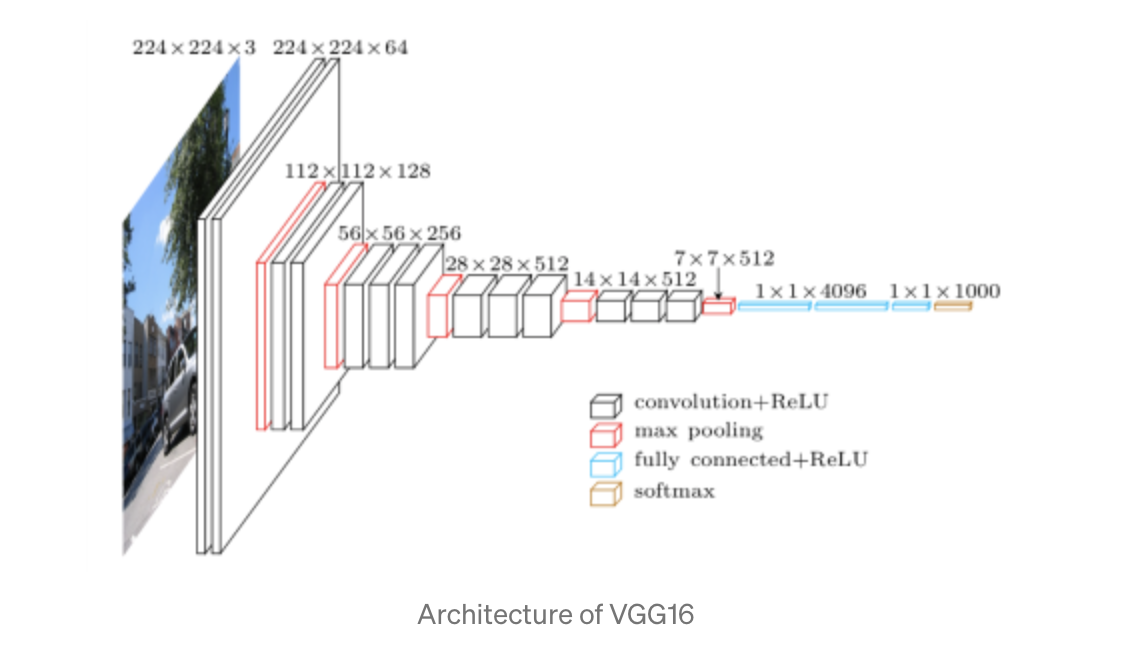

In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import keras
# Deep learning libraries
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import seaborn as sns

# Explore Data Analysis

In [2]:
path_normal = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images"
path_covid = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images"
path_lung_opacity = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images"
path_viral_pneumonia = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images"

len_normal = len(os.listdir(path_normal))
len_covid = len(os.listdir(path_covid))
len_lung_opacity =  len(os.listdir(path_lung_opacity))
len_viral_pneumonia = len(os.listdir(path_viral_pneumonia))

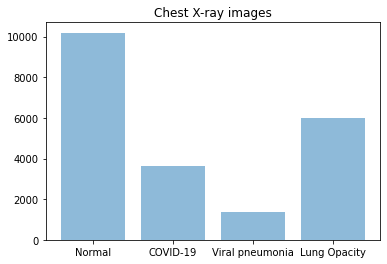

In [3]:
objects = ('Normal', 'COVID-19', 'Viral pneumonia', 'Lung Opacity')
y_pos = np.arange(len(objects))
performance = [len_normal, len_covid, len_viral_pneumonia, len_lung_opacity]

plt.bar(y_pos,performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Chest X-ray images')

plt.show()

**Overview Chest X-ray images**

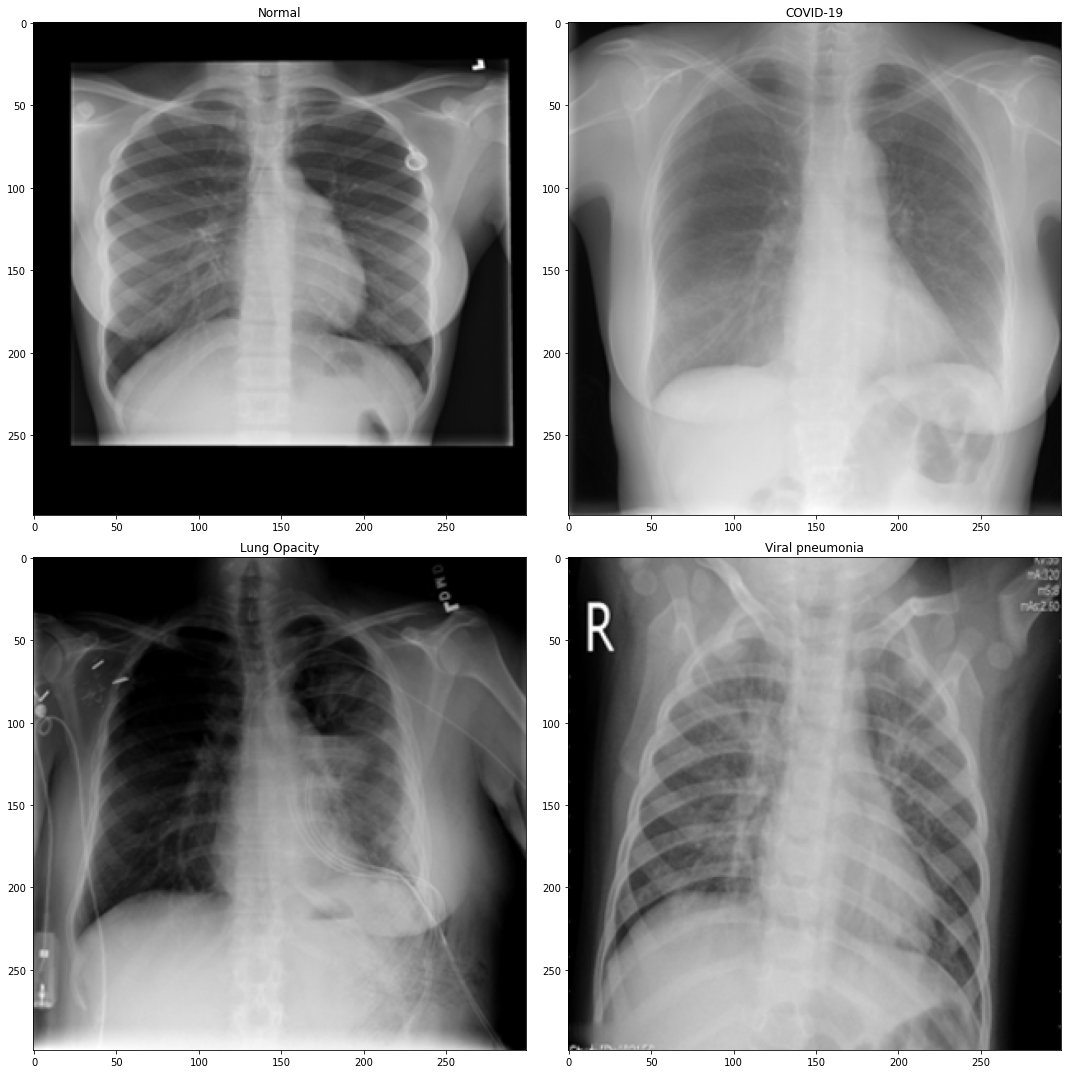

In [4]:
labels = ['Normal', 'COVID-19','Lung Opacity', 'Viral pneumonia']
img1 = path_normal+"/Normal-1.png"
img2 = path_covid+"/COVID-1994.png"
img3 = path_lung_opacity+"/Lung_Opacity-1.png"
img4 = path_viral_pneumonia + "/Viral Pneumonia-1.png"

imgs = [img1, img2, img3, img4]

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.ravel()
plt.tight_layout()

for i in range(0,4):

    ax[i].imshow(plt.imread(imgs[i]), cmap='gray')
    ax[i].set_title(labels[i])

**Load data and Preprocess**

In [5]:
from PIL import Image, ImageOps
def resize_image(imgpath):
    img = np.array(ImageOps.grayscale(Image.open(imgpath)).resize((150, 150), Image.ANTIALIAS))
    return img

In [6]:
import os
x_ = list()
y = list()

for i in os.listdir(path_normal):
    try:
        imgpath = path_normal+"/"+i
        img = resize_image(imgpath)
        x_.append(img)
        y.append(0)
    except:
        None
        
for i in os.listdir(path_covid):
    try:
        imgpath = path_covid+"/"+i
        img = resize_image(imgpath)
        x_.append(img)
        y.append(1)
    except:
        None
for i in os.listdir(path_lung_opacity):
    try:
        imgpath = path_lung_opacity+"/"+i
        img = resize_image(imgpath)
        x_.append(img)
        y.append(2)
    except:
        None
for i in os.listdir(path_viral_pneumonia):
    try:
        imgpath = path_viral_pneumonia+"/"+i
        img = resize_image(imgpath)
        x_.append(img)
        y.append(3)
    except:
        None
x_ = np.array(x_)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  This is separate from the ipykernel package so we can avoid doing imports until


> ### Split test, train, validation data

In [7]:
from keras.utils.np_utils import to_categorical

y = to_categorical(y,num_classes = 4)

classNames = ["normal","COVID_19", "lung_opacity","viral_pneumonia"]
print(classNames)

['normal', 'COVID_19', 'lung_opacity', 'viral_pneumonia']


In [8]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x_,y,test_size = 0.2,random_state = 20)

x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size = 0.1,random_state = 40)

**Clases: Normal, COVID-19, Lung Opacity, Viral pneumonia**

In [9]:
print(x_train.shape)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)
print(y_train.shape)

(15238, 150, 150)
(15238, 4)


In [ ]:
unique, counts = np.unique(np.argmax(y_train,axis=1), return_counts=True)
uniqueVal, countsVal = np.unique(np.argmax(y_val,axis=1), return_counts=True)
dict(zip(unique, counts))

In [ ]:
dict(zip(uniqueVal, countsVal))

# Build VGG16 model

In [10]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import Dense, Flatten
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
def createModel():
    _input = Input(shape=(150,150,1))

    conv1  = Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu")(_input)
    conv2  = Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu")(conv1)
    pool1  = MaxPooling2D((2, 2))(conv2)
    

    conv3  = SeparableConv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(pool1)
    conv4  = SeparableConv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(conv3)
    conv4  = BatchNormalization()(conv4)
    pool2  = MaxPooling2D((2, 2))(conv4)

    conv5  = SeparableConv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(pool2)
    conv6  = SeparableConv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv5)
    conv6  = BatchNormalization()(conv6)
    pool3  = MaxPooling2D((2, 2))(conv6)

    conv7  = SeparableConv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool3)
    conv8  = SeparableConv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv7)
    conv8 = BatchNormalization()(conv8)
    pool4  = MaxPooling2D((2, 2))(conv8)
    pool4 = Dropout(rate=0.2)(pool4)
    
    conv9 = SeparableConv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool4)
    conv10 = SeparableConv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv9)
    conv10 = BatchNormalization()(conv10)
    pool5  = MaxPooling2D((2, 2))(conv10)
    pool5 = Dropout(rate=0.2)(pool5)

    flat   = Flatten()(pool5)
    dense1 = Dense(512, activation="relu")(flat)   
    dropout1 = Dropout(rate=0.7)(dense1)
    dense2 = Dense(128, activation="relu")(dropout1)
    dropout2 = Dropout(0.5)(dense2)
    output = Dense(4, activation="sigmoid")(dropout2)
    model  = Model(inputs=_input, outputs=output)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

**Hyper parameters**

In [11]:
from tensorflow.keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
sd=[]
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = [1,1]

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        sd.append(step_decay(len(self.losses)))
        print('lr:', step_decay(len(self.losses)))

epochs = 50
learning_rate = 0.0001
decay_rate = 5e-6

model = createModel()

adam = Adam(lr=learning_rate,decay=decay_rate)
# sgd = SGD(lr=0.0001, momentum=0.9, decay=decay_rate)
model.compile(loss='mean_squared_error',optimizer=adam,metrics=['mean_absolute_error','accuracy'])
tf.keras.utils.plot_model(model,to_file='model.png', show_shapes=True, show_layer_names=True)
model.summary()

def step_decay(losses):
    i = float(2*np.sqrt(np.array(history.losses[-1])))

    if i <0.6:
        lrate=0.001*1/(1+0.7*len(history.losses))
        decay_rate=2e-6
    else:
        lrate =0.0001
   
    return lrate
history=LossHistory()
lrate=LearningRateScheduler(step_decay)
early = EarlyStopping(monitor='val_accuracy', mode='min', patience=20)

myhistory = model.fit(x_train,y_train,validation_data=
                      (x_val, y_val),batch_size=32, 
                      epochs=epochs,callbacks=[history,lrate,early], verbose=1)

2022-10-03 14:26:17.025247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 14:26:17.039851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 14:26:17.044100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 14:26:17.048936: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)        128   

2022-10-03 14:26:19.846683: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-10-03 14:26:22.127304: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


477/477 [==============================] - 37s 70ms/step - loss: 0.1312 - mean_absolute_error: 0.2649 - accuracy: 0.6285 - val_loss: 0.2412 - val_mean_absolute_error: 0.4786 - val_accuracy: 0.1600
lr: 0.0001
Epoch 2/50
477/477 [==============================] - 33s 69ms/step - loss: 0.0853 - mean_absolute_error: 0.1714 - accuracy: 0.7790 - val_loss: 0.1340 - val_mean_absolute_error: 0.2071 - val_accuracy: 0.6210
lr: 0.0002631578947368421
Epoch 3/50
477/477 [==============================] - 33s 69ms/step - loss: 0.0709 - mean_absolute_error: 0.1355 - accuracy: 0.8181 - val_loss: 0.0636 - val_mean_absolute_error: 0.1104 - val_accuracy: 0.8359
lr: 0.00022222222222222223
Epoch 4/50
477/477 [==============================] - 33s 68ms/step - loss: 0.0569 - mean_absolute_error: 0.1081 - accuracy: 0.8563 - val_loss: 0.0594 - val_mean_absolute_error: 0.1158 - val_accuracy: 0.8400
lr: 0.00019230769230769233
Epoch 5/50
477/477 [==============================] - 32s 68ms/step - loss: 0.0477 - mea

In [13]:
def showChartEpochAccuracy(hist):
    #Plot training and validation Loss
    fig, axarr = plt.subplots(1,3, figsize=(15,5),sharex=True)

    sns.set(style="ticks", font_scale = 1)
    sns.despine(top=True, right=True, left=False, bottom=False)

    historyDF = pd.DataFrame.from_dict(hist.history)

    ax = sns.lineplot(x =historyDF.index, y = hist.history['accuracy'],ax=axarr[0],label="Training");
    ax = sns.lineplot(x =historyDF.index, y = hist.history['val_accuracy'],ax=axarr[0],label="Validation");
    ax.set_ylabel('Recall')

    ax = sns.lineplot(x =historyDF.index, y = hist.history['loss'],ax=axarr[1],label="Training");
    ax = sns.lineplot(x =historyDF.index, y = hist.history['val_loss'],ax=axarr[1],label="Validation");
    ax.set_ylabel('Loss')
    ax = sns.lineplot(x =historyDF.index, y = hist.history['lr'],ax=axarr[2]);
    ax.set_ylabel('Learning Rate')    
    axarr[0].set_title("Training and Validation Set - Accuracy")
    axarr[1].set_title("Training and Validation Set - Loss")
    axarr[2].set_title("Learning Rate during Training")

    for ax in axarr:
        ax.set_xlabel('Epochs')

    plt.suptitle('Training Performance Plots',fontsize=18, weight = 'bold');
    fig.tight_layout(pad=2.0)      
    plt.show()

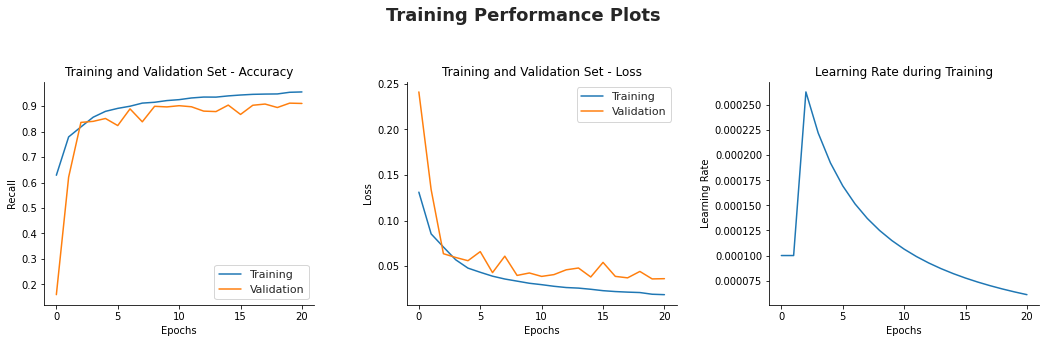

In [14]:
showChartEpochAccuracy(myhistory)

# Test and Evaluate Model

**Predict with test data**

In [15]:
# Get predictions
mypredict = model.predict(x_test)
pred = np.argmax(mypredict, axis=-1)
print(pred)

[0 0 0 ... 2 1 2]


In [16]:
evalute = model.evaluate(x_test, y_test)

133/133 [==============================] - 1s 8ms/step - loss: 0.0337 - mean_absolute_error: 0.0473 - accuracy: 0.9190


In [17]:
print("Accuracy: {:.2f}%".format(evalute[2] * 100))  
print("Loss: {}".format(evalute[0])) 

Accuracy: 91.90%
Loss: 0.03368568420410156


## Confusion matrix & Classification report

A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix. The confusion matrix shows the ways in which your classification model is confused when it makes predictions. It gives us insight not only into the errors being made by a classifier but more importantly the types of errors that are being made.

<AxesSubplot:>

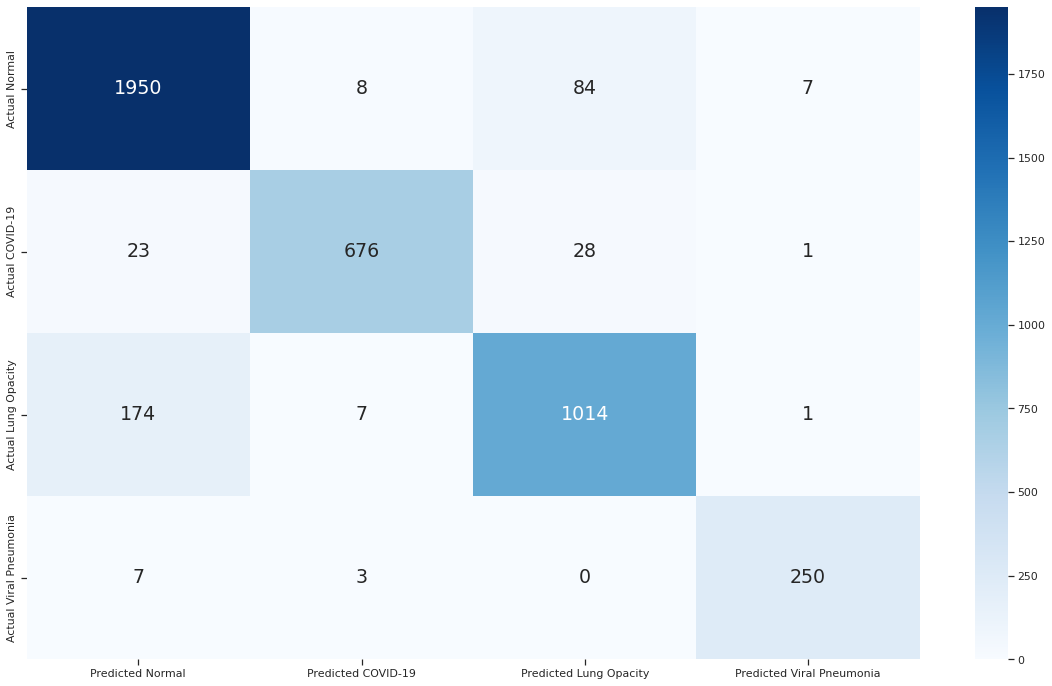

In [18]:
# Example of a confusion matrix in Python
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

cm = pd.DataFrame(data=confusion_matrix(np.argmax(y_test, axis=1), mypredict.argmax(axis=1), labels=[0,1,2,3]),index=["Actual Normal", "Actual COVID-19", "Actual Lung Opacity", "Actual Viral Pneumonia"],
columns=["Predicted Normal", "Predicted COVID-19", "Predicted Lung Opacity", "Predicted Viral Pneumonia"])
fig, ax = plt.subplots(figsize=(20,12))
plt.rcParams.update({'font.size': 19})
sns.heatmap(cm,cmap="Blues",annot=True,fmt="d",ax=ax)

In [19]:
print ('Accuracy Score :',accuracy_score(y_test.argmax(axis=1), mypredict.argmax(axis=1)) )
print ('Report : ')
print (classification_report(y_test.argmax(axis=1), mypredict.argmax(axis=1)) )

Accuracy Score : 0.9189699976376092
Report : 
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2049
           1       0.97      0.93      0.95       728
           2       0.90      0.85      0.87      1196
           3       0.97      0.96      0.96       260

    accuracy                           0.92      4233
   macro avg       0.94      0.92      0.93      4233
weighted avg       0.92      0.92      0.92      4233



**Visualization Learning Rate**

In [ ]:
print('Learning Rate', sd)

# Show Result Prediction

if predicted label is equal to real label we can see the text and bar in blue.
if predicted label is not equal to real label we can see the text and bar in red.

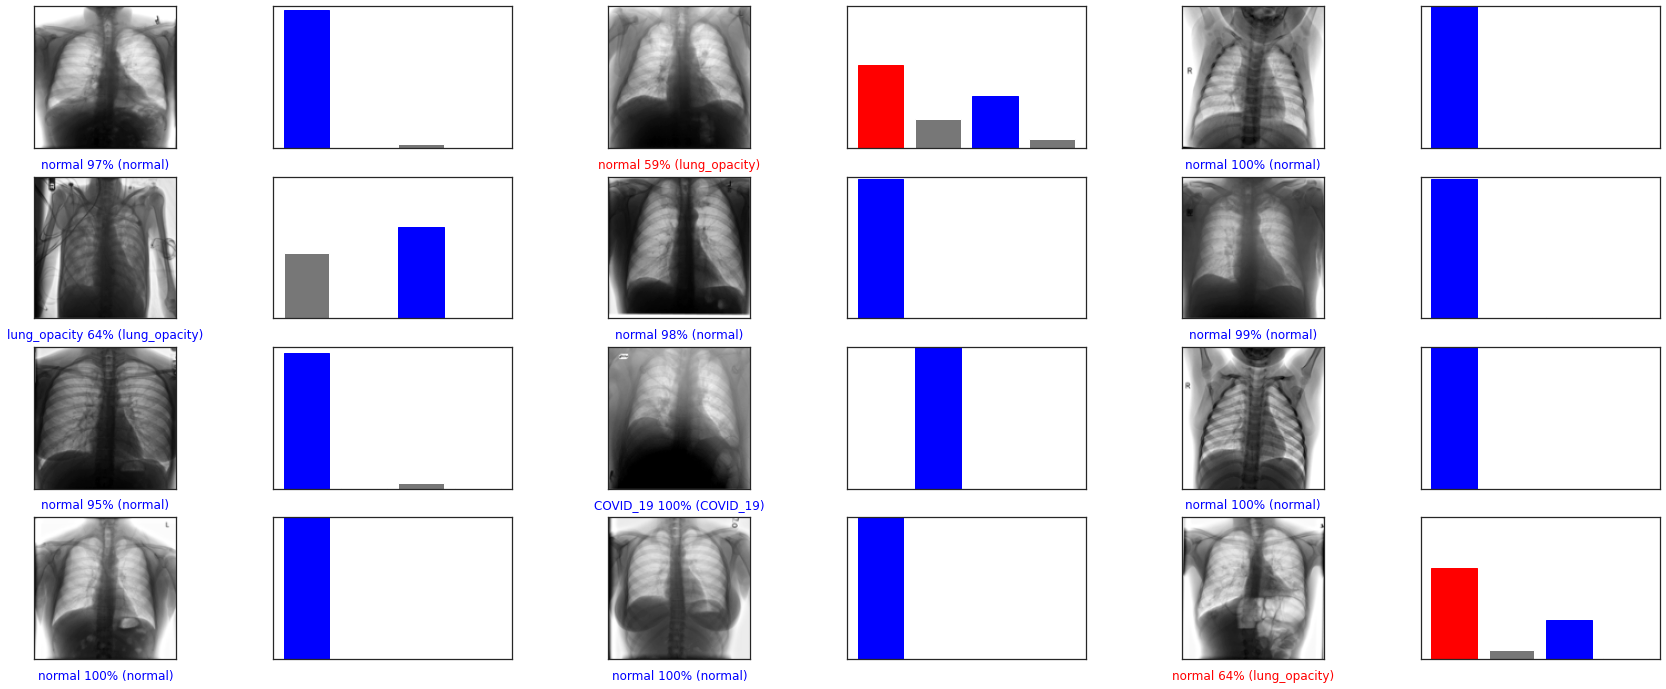

In [20]:
import matplotlib.pyplot as plt

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(4), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_label)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = cv2.resize(img,(128,128))
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    true_label= np.argmax(true_label)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)
    
def showResultPrediction(predictions):
    num_rows = 4
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(5*2*num_cols, 3*num_rows))
    for i in range(num_images):
      plt.subplot(num_rows, 2*num_cols, 2*i+1)
      plot_image(i, predictions, y_test, x_test)
      plt.subplot(num_rows, 2*num_cols, 2*i+2)
      plot_value_array(i, predictions, y_test)
    plt.show()

showResultPrediction(mypredict)

# References
https://www.kaggle.com/code/andrespanamito/covid-detection-with-vgg-16